<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/CAM/%5BGD_5%5DClass_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **10-9. 프로젝트: CAM을 만들고 평가해 보자**

## **0. 라이브러리 버전 확인하기**
사용할 라이브러리 버전을 확인해봐요.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(Image.__version__)

2.9.2
1.21.6
4.6.0
7.1.2


## **1. 데이터 불러오기**

In [2]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJFBQPN/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJFBQPN/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


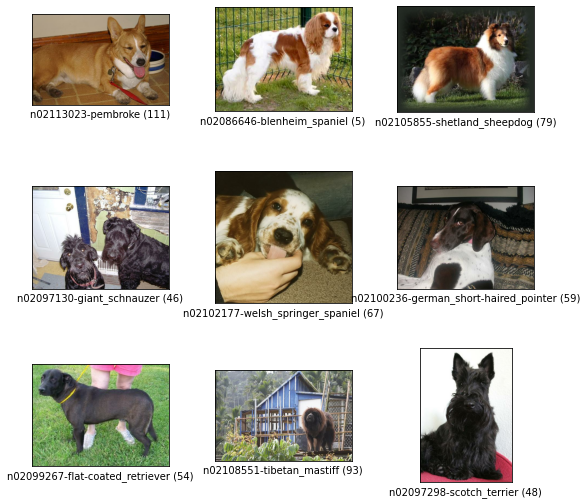

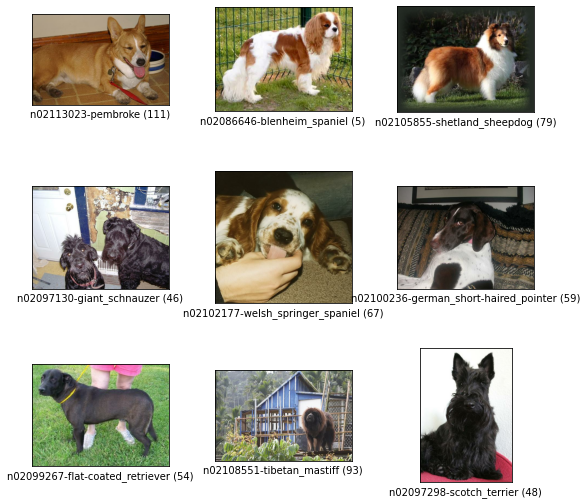

In [3]:
tfds.show_examples(ds_train, ds_info)

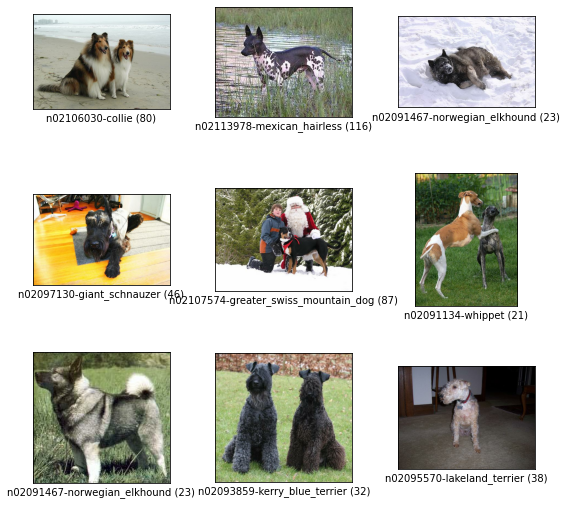

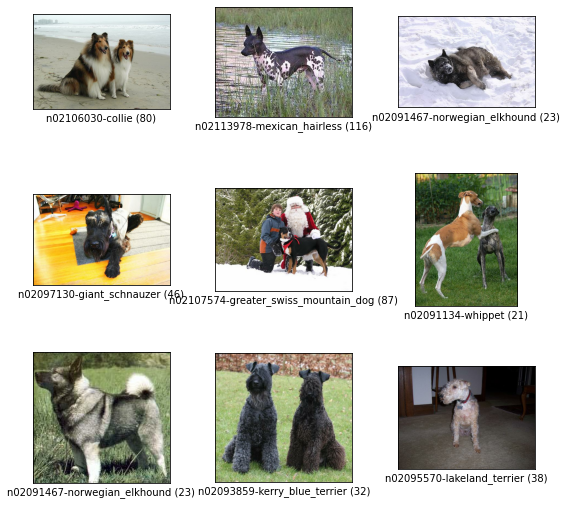

In [4]:
tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## **2. CAM 구현하기**
> 이번 노드에 나왔던 CAM을 직접 구현해 봅시다.

### **CAM**

객체 위치 추출이 가능한 모델 구조인 CAM을 만들어봅시다. 기존 이미지 분류모델에서 마지막 여러층의 FC layer에 의해 flatten 되므로 위치정보가 소실되나,  
CAM에서는 GAP를 이용하고 FC layer도 하나만 사용해서 위치정보를 살립니다.

결론 : 마지막 층에서 GAP 사용하기

### **(1) CAM 모델 만들기**

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### **(2) 간단한 전처리**

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


 ### **(3) 모델 학습**

In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


[earlystopping참고](https://sevillabk.github.io/1-early-stopping/)

In [11]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=50,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
#     callbacks=[es]
# )

In [12]:
# import os

# cam_model_path = '/content/drive/MyDrive/dataset/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

50 Epoch 학습시키고 저장해줬습니다.

이제 학습된 모델에서 CAM을 생성하기 위해 `get_one` 함수를 정의해 줍니다.  
배치단위가 아니라 개별 이미지 데이터 단위로 이뤄지므로, 데이터셋에서 한 장씩 뽑게 했습니다.

In [13]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


108


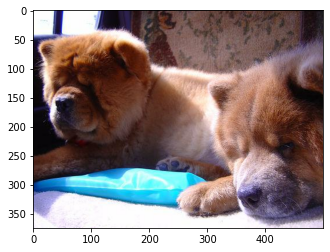

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

데이터가 준비되었으니 CAM을 생성하기 위해 미리 준비된 학습모델을 불러와봅니다.

In [24]:
cam_model_path = '/content/drive/MyDrive/dataset/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

**참고**  
[deepcopy](https://crackerjacks.tistory.com/m/14)  
: 배열을 깊은 복사해서 원본 배열의 보존을 하기 위해 deepcopy함  
리스트를 복사할 때, 얕은 복사를 통해 주소값만 복사되어 복사된 객체에서 값을 바꾼것이 원본 객체의 값도 바꾸는 것을 막기 위해 깊은 복사를 사용한다.

In [27]:
def generate_cam(model, item):
    cam_image = None
    item = copy.deepcopy(item) # item을 깊은 복사함
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)
    # normalize하고 resize된 image와 label이 담김

    # 학습한 모델에서 원하는 layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 convolution layer의 output을 얻을 수 있다
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs,predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있습니당
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타남
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize하긔
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

print("shoong~")

shoong~


> 만든 함수로 CAM 이미지를 생성합시다.

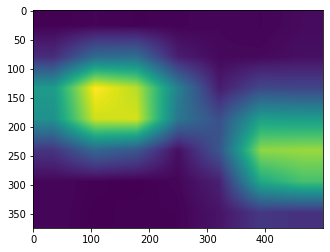

In [29]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

위에 샘플이미지를 보면 정확하게 위치를 표현하고 있네요!

> 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수를 만들어보세요.
* [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [30]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

---

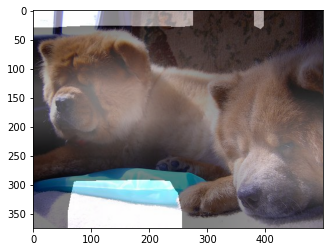

In [34]:
# visualize_cam_on_image() 함수 사용

#type(item['image'].np())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

멍멍이 얼굴에 잘 초점이 맞춰져있습니다.

## **3. Grad-CAM 구현하기**
> 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

### **Grad-CAM**

Grad-CAM 은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에  GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM이미지를 구하기 위해서는 레이어의 채널별 가중치(Weights) 와 레이어에서 나온 채널별 특성맵을 가중합해주어 cam_image를 얻게됩니다.   
이전 스텝에서 본 CAM함수와 달리, grad-CAM은 이번에는 어떤 레이어든 CAM이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상이 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.  
아래 `generate_grad_cam()`에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

일단 새로운 이미지를 가져옵니다.

80


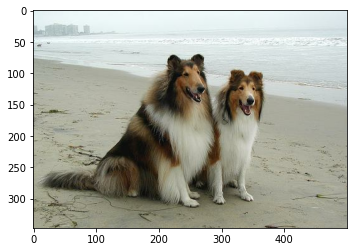

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [38]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # grad cam 에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과
    # output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

        loss = pred[:, class_idx] 
        # 원하는 class(여기서는 정답으로 활용), 예측값 얻기
        output = conv_output[0]
        # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0]
        # 에측값에 따른 layer의 gradient 얻기

    weights = np.mean(grad_val, axis = (0,1))
    # gradient의 GAP로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map 얻기

        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

> 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.




#### conv3_block3의 CAM 이미지를 출력

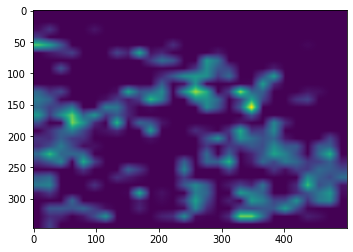

In [46]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

> 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화해 보세요.

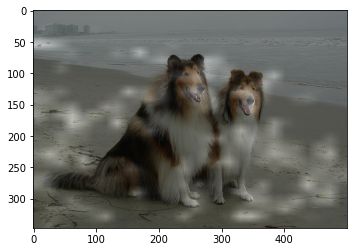

In [47]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

#### conv4_block3의 CAM이미지를 출력

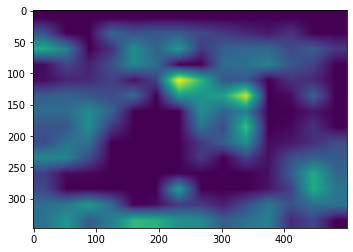

In [48]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

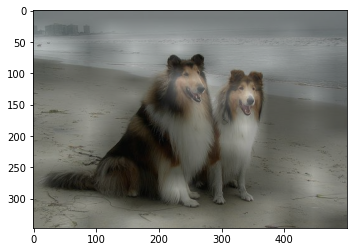

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### conv5_block3 의 CAM 이미지를 출력

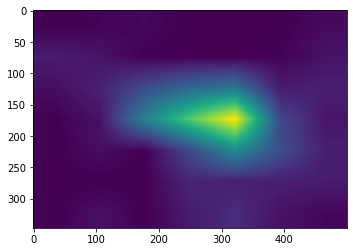

In [50]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

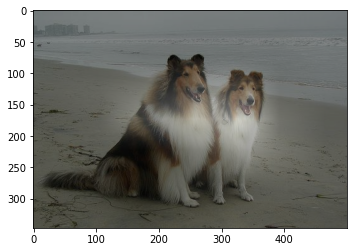

In [51]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

확실히 레이어가 쌓일수록 CAM 이미지가 활성화되는 부분이 명확해짐을 알 수 있었습니다.

## **4. 바운딩 박스 구하기**
> 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.


67


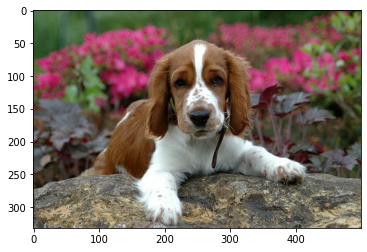

In [54]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

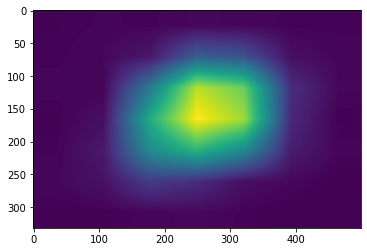

In [55]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던  `generate_cam()`을 활용해서 cam 이미지를 뽑았습니다.  
아래 `get_bbox()`함수는 
1. 바운딩 박스를 만들기 위해서  socre_thresh를 받아 역치값 이하의 바운딩박스는 없앱니다.  
2. opencv의 `findContours()`와 `minAreaRect()`로 사각형을 찾습니다.   
    rotated_rect라는 회전된 바운딩 박스를 얻을 수 있습니다. 
3. `boxpoints()`로 이를 꼭지점으로 바꾸어 줍니다. 
4. int 자료형으로 변환!

In [61]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('🚗=3')

🚗=3


> 위에서 얻은 바운딩 박스를 시각화해 보세요.

In [62]:
rect = get_bbox(cam_image)
rect

array([[ 91,  29],
       [441,  29],
       [441, 296],
       [ 91, 296]])

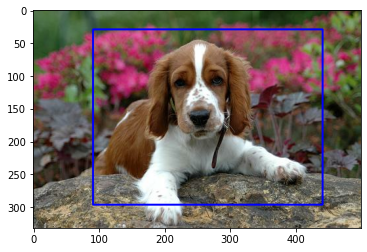

In [64]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

tada~

## **5. IoU 구하기**
> **정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box)** 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수를 만들어 주세요.

아까 추출된 bbox 좌표는 normalized형태로 추출됐습니다. (y_min, x_min, y_max, x_max)  
minmax 형태로 치환합니다!

In [65]:
rect

array([[ 91,  29],
       [441,  29],
       [441, 296],
       [ 91, 296]])

In [68]:
print(rect[:,0]  )
# x를 쭉 뽑은겨
print(rect[:,1]  )
# y를 쭉 뽑은겨

[ 91 441 441  91]
[ 29  29 296 296]


In [69]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        # y뽑은거중에서 최소 = y_min
        rect[:,0].min()/float(image.shape[1]),  
        # x뽑은거중에서 최소 = x_min
        rect[:,1].max()/float(image.shape[0]), 
        # y 뽑은거중에서 최대 = y_max
        rect[:,0].max()/float(image.shape[1]) 
        # x 뽑은거중에서 최대 = x_max
    ]
    return bbox

print("🚗=3")

🚗=3


In [70]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08734939759036145, 0.182, 0.891566265060241, 0.882]

ground truth bbox를 확인해 봅니다.

In [71]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

이를 바탕으로 iou를 계산해봅니다.

In [72]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou
print("🚗=3")

🚗=3


2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [73]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7425216461282889

잘 맞네용

## **🍤 루브릭**
| 평가문항 | 상세기준 | 학습결과 |
|:---:|:---:|:---:|
| 1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가? | ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다. | O |
| 2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? | CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다. | O |
| 3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? | CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다. | O |

## **✍ 회고**

* grad-cam에서는 layer마다 activation map을 뽑아볼 수 있어서 매우 도움될 것 같았다. 각 레이어마다 무엇을 보고 있는지 나도 볼 수 있으니까!

* 문태섭교수님의 XAI 강의를 들은 적이 있었는데 거기서 봤던 CAM, GRAD-CAM을 구현해 볼 수 있어서 좋았다. 
    * RISE, LIME과 같은 다른 모델도 사용해보고 싶다.  
    확실히 이 두개는 CAM과 비교해서 더 clear한 map을 출력했는데, 그만큼 계산비용이 크고 계산 복잡도가 커진다는 단점이 있었다.

![image](https://user-images.githubusercontent.com/108614874/196870024-a78d16d4-5c0e-4a28-b89c-878621eee22b.png)
출처: 서울대학교 전기정보공학부 문태섭 교수님 (M.IN.D Lab)

* 당연하게도 2 epoch 학습시킨 모델과 50 epoch 학습시킨 모델의 iou 차이가 확연했다. 
* XAI 분야에 대해 겉핥기지만 배워볼 수 있어서 좋았다. 사실 내가 CV를 선택한 이유 중 하나도 직관적으로 시각화가 가능하다는 점이었는데, CAM이 학습과정 중 활성화되는 영역을 시각화해서 모델이 어떤곳을 보고 어떤 클래스임을 짐작하고 있는지 알 수 있다니 ~~


* GAP를 사용하는게 중요했다. FC layer로 꾹ㄱ꾹 눌러서 예측결과를 내는게 아니라 average pooling을 이용해서 각 클래스별 확률을 얻어 해석을 쉽게했다~!

### **🔖 참고문헌**

* [unit8? uint8!](https://stackoverflow.com/questions/66023331/try-to-make-black-image-but-getting-error-for-np-unit8)